<a href="https://colab.research.google.com/github/gupta-keshav/HUSE-TF/blob/master/HUSE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
This notebook tries to implement Hierarchical Universal Semantic Embedding(HUSE) Model. HUSE tries to project objects(images or text) from different modalities to a universal shared space and then use the projections to classify the objects as well as maintain the semantic relation.
<img src="https://drive.google.com/uc?id=16wQ1Z2o2MitrrK9lbNmGFec3gM8_qG8D" width="600" layout="centre">

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importing all the necessary libraries

In [0]:
import pandas as pd
import numpy as np
import cv2 as cv
import glob
import os
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook


import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras import metrics
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.inception_v3 import preprocess_input, InceptionV3


import warnings
warnings.filterwarnings("ignore")
from IPython.display import Image

from sklearn.metrics import accuracy_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_distances
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import re
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
# Setting seed values for various RNG for reproducible results
seed_value = 48

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
tf.compat.v1.set_random_seed(seed_value)

In [0]:
df = pd.read_csv('/content/drive/My Drive/HUSE/training.csv')
print(df.shape)
df.head()

(65714, 3)


,image,name,classes
0,5da821eb7f3e301b4504bb4a_0.jpg,Marc Jacobs Beauty Eye-Conic Longwear Eyeshad...,beauty<makeup<eyeshadow
1,5da81cde7861c2af6a5a88cf_0.jpg,Marc Jacobs Beauty Eye-Conic Longwear Eyeshad...,beauty<makeup<eyeshadow
2,5da8219a6504fb65da0050aa_0.jpg,Prada Wool sweater,clothing<knitwear<fine knit
3,5da821856504fb65cea703cf_0.jpg,Prada Printed silk-satin twill straight-leg p...,clothing<pants<straight leg
4,5da82200b25b035d1d17bec6_0.jpg,Prada Cropped chain-trimmed printed crepe str...,clothing<pants<straight leg


In [0]:
#Checking if any element is null
df.isnull().any()

image      False
name       False
classes    False
dtype: bool

In [0]:
from zipfile import ZipFile
with ZipFile('/content/drive/My Drive/HUSE/images.zip', 'r') as ZIP:   ZIP.extractall() #extracting the images
print('All Files Extracted!')
IMAGES_DIR = '/content/netaporter_gb_images'
extracted_images = 0
for img in os.listdir(IMAGES_DIR): 
    if os.path.isfile(os.path.join(IMAGES_DIR, img)):    extracted_images += 1
assert(extracted_images == df.shape[0]) #making sure all the images has been extracted
print('Number of extracted images {}'.format(extracted_images))

All Files Extracted!
Number of extracted images 65714


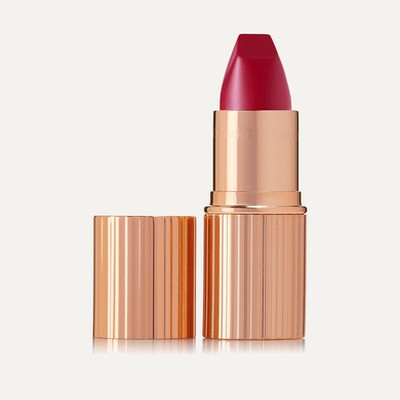

In [0]:
#displaying a random image
image_name = df.iloc[np.random.randint(0, 1000)]['image']
Image(f'{IMAGES_DIR}/{image_name}')

# Part 1: Obtaining Embeddings
First part of building HUSE Model consists of obtaining the image and text embeddings from some pre-trained models.

For image embeddings I'll pass the given images from the pre-trained InceptionV3 Neural Network and since images are passed with the help of ImageDataGenerator of keras it I'll augment and preprocess the image using the ImageDataGenerator only.

InceptionV3 would generate 2048 dimensional embedding for each image, To reduce dimentionality of final embeddings I'll use PCA and finally for each image embedding of size 512 would be obtained

In [0]:
# setting up the ImageDataGenerator for pre-processing and augmentation of the images. 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
batch_size = 319   
datagen = ImageDataGenerator(
        preprocessing_function = preprocess_input, #pre processing the images according to the neural network
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

images_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory=IMAGES_DIR,
    x_col='image',
    y_col='classes',
    target_size=(299, 299),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False # it is important to keep the shuffle false that way the embeddings and image name in the dataframe will remain consistent
)

Found 65714 validated image filenames belonging to 48 classes.


In [0]:
# using the pre-trained InceptionV3 Neural Network to generate 2048 dimensional embedding for each image

from multiprocessing import Pool
def create_model_and_predict():
    np.random.seed(seed_value)
    image_vectors = np.zeros(shape=(extracted_images, 2048)) # np array to store embeddings
    embeddings_model = InceptionV3(include_top=False, input_shape=(299, 299, 3), weights='imagenet', pooling='avg')
    idx = 0
    print('Starting!')
    for images_batch, labels_batch in tqdm_notebook(images_generator):
        vectors_batch = embeddings_model(images_batch)
        image_vectors[idx:idx+batch_size] = vectors_batch
        idx += batch_size
        if idx >= extracted_images-1:
            break
    return image_vectors

'''
Since Tensorflow tends to give all the GPU memory to the Neural Network and it is very difficult to free the memory
without restarting the kernel. I used a workaround which is to is to wrap up the model creation and prediction part in
a function then use subprocess for the heavy work. when training is done, subprocess will be terminated and GPU memory will be free. 
'''

def run():
    with Pool(1) as p:
        return p.apply(create_model_and_predict, ())
vec = run()

Starting!


In [0]:
#running PCA to reduce the dimensionality of embeddings obtained by IneptionV3
pca = PCA(n_components=512)
image_embeddings = pca.fit_transform(vec)
print('Cumulative explained variation for 512 principal components: {}'.format(np.sum(pca.explained_variance_ratio_)))
print(np.shape(image_embeddings))
np.save('image_embeddings.npy', image_embeddings)

Cumulative explained variation for 512 principal components: 0.9184639704232076
(65714, 512)


For Text Embeddings first I will preprocess/clean the text. Then the texts are passed through pre-trained BERT Model which provides 768 dimensional embedding for each text and to reduce the dimensionality I'll again use PCA.

In [0]:
# decontracting all contracted words
def decontracted(phrase):
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
# Cleaning the texts
def preprocessing(phrase):
    result = decontracted(str(phrase))      
    result = result.strip()             #remove leading and ending spaces
    result = result.split()             #Split to tokenize words
    ps = PorterStemmer()                #reducing words to their word stem or base
    result = [ps.stem(word) for word in result if not word in set(stopwords.words('english'))]  #remove the stopwords
    result = ' '.join(result)           #Joining all the tokens 
    return result

In [0]:
description = df['name'].str.lower()        #Convert text to lowercase
sentences = description.map(preprocessing)
print(sentences[:4])

0    marc jacob beauti eye-con longwear eyeshadow p...
1    marc jacob beauti eye-con longwear eyeshadow p...
2                                   prada wool sweater
3       prada print silk-satin twill straight-leg pant
Name: name, dtype: object


In [0]:
#installing all the necessary dependencies
from IPython.utils import io
with io.capture_output() as captured: #as the commands used below print stuff that is not necessary I used capture to hide their Output
    !pip install -U sentence-transformers
    !git clone https://github.com/UKPLab/sentence-transformers.git
    !cd sentence-transformers/
    !pip install -e .
print('Installation Complete')

Installation Complete


In [0]:
#Downloading the pre-trained model
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('bert-base-nli-mean-tokens')

100%|██████████| 405M/405M [00:44<00:00, 9.09MB/s]


In [0]:
#passing the texts through model
texts = model.encode(sentences)
print(np.shape(texts))

(65714, 768)


In [0]:
#reducing the dimensionality using PCA
pca = PCA(n_components=512)
texts = pca.fit_transform(texts)
print('Cumulative explained variation for 512 principal components: {}'.format(np.sum(pca.explained_variance_ratio_)))
print(np.shape(texts))
np.save('/content/text_embeddings.npy', texts) 

Cumulative explained variation for 512 principal components: 0.9960530063662713
(65714, 512)


Class embeddings are obtained by passing the classes through the Sentence Encoder

In [0]:
# Replace < with space so that the classes can be processed by the sentence encoder
df['classes'] = df['classes'].str.replace('<',' ')
all_classes = df['classes'].unique()
len(all_classes)

48

In [0]:
#downloading and extracting the sentence encoder
!mkdir /content/universal  
!curl -L "https://tfhub.dev/google/universal-sentence-encoder-large/3?tf-hub-format=compressed" | tar -zxvC /content/universal/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0  745M    0  130k    0     0   223k      0  0:56:55 --:--:--  0:56:55  223k./
./tfhub_module.pb
./variables/
./variables/variables.data-00000-of-00001
 91  745M   91  683M    0     0  54.9M      0  0:00:13  0:00:12  0:00:01 59.4M./variables/variables.index
./assets/
./saved_model.pb
100  745M  100  745M    0     0  56.4M      0  0:00:13  0:00:13 --:--:-- 61.2M


In [0]:
# passing the classes through the sentence encoder to obtain the respective encodings
def embed_useT(module):
    with tf.Graph().as_default():
        sentences = tf.compat.v1.placeholder(tf.string)
        embed = hub.Module(module)
        embeddings = embed(sentences)
        session = tf.compat.v1.train.MonitoredSession()
    return lambda x: session.run(embeddings, {sentences: x})
embed_fn = embed_useT('/content/universal')

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


In [0]:
class_name = all_classes
labels_embeddings = embed_fn(class_name)
print(np.shape(labels_embeddings))
np.save('/content/class_embeddings.npy',labels_embeddings)
np.save('/content/class_name.npy', class_name)

(48, 512)


# Part 2: Defining the Model
In this part Image tower and Text tower is defined which will take the pre-trained embeddings obtained above and project those embeddings onto the universal shared space, this is done with the help of classification layer which is common for both the image tower and text tower.

### Architecture Of Image Tower And Text Tower

Image Tower consists of 5 hidden layers of 512 hidden units each and text tower consists of 2 hidden layers of 512 hidden units each. A dropout of 0.15 is used between all the hidden layers. Output of both the towers is L2 Normalized and passed onto the classification layer for the classification of the object.

In [0]:
inputImage = Input(shape=(512, ))
inputText =  Input(shape=(512, ))
 
#constructing the image tower which consists of 5X Dense layers with 512 hidden units with Dropout of 0.15 between them
x = Dense(512, 'relu')(inputImage)
x = Dropout(0.15)(x)
x = Dense(512, 'relu')(x)
x = Dropout(0.15)(x)
x = Dense(512, 'relu')(x)
x = Dropout(0.15)(x)
x = Dense(512, 'relu')(x)
x = Dropout(0.15)(x)
outputImage = Dense(512, 'relu')(x)

# constructing the text tower which consists of 2X Dense layers with 512 hidden units with Droupout of 0.15 between them
y = Dense(512, 'relu')(inputText)
y = Dropout(0.15)(y)
outputText = Dense(512, 'relu')(y)

outputModel = Dense(48, activation='softmax') # same classifier layer for image and text tower

# passing the L2 normalized image and text embeddings to the classifier layer 
outImage = outputModel(tf.keras.backend.l2_normalize(outputImage))
outText = outputModel(tf.keras.backend.l2_normalize(outputText))

In [0]:
# Now we'll construct 5 models based on the requirements each model would have different input and output from each other

model = Model([inputImage, inputText], [outImage, outText]) # main model with both image and text embeddings as input and class as output

# models for creating the image and text embedding in the universal shared space
imageEmbeddings = Model(inputImage, outputImage) 
textEmbeddings = Model(inputText, outputText)

# models for obtaining class outout from image or text data
imageModel = Model(inputImage, outImage)
textModel = Model(inputText, outText)

# Part 3: Defining Losses and Training the model

### Losses
We define 3 kinds of loss in this model, Cross Classification Loss, Modal loss, Semantic Loss. For classification loss categorical crossentory Loss is used, but for the later 2 losses custom methods are used which involves calculating distance between various embeddings, So the distance metric used is Cosine Distance

In [0]:

def dist(embedding1, embedding2):
    return cosine_distances(embedding1, embedding2)

### Cross Modal Loss
The formula used to calculate the cross modal loss is the following:

<img src="https://drive.google.com/uc?id=1hbhF8VxhcjgR0FI7QZDLPTpvdPy2W3_M" width="400">

Here PhiI represents the projection of image embeddings onto universal shared space and PhiT represents the projection of text embeddings onto universal shared space. The main purpose of this Loss is to reduce the cross modal gap, the distance between universal image and text embeddings corresponding to the same instance

In [0]:
def loss_modal(embeddingsImage, embeddingsText):
    distance = dist(embeddingsImage, embeddingsText) #this constructs the matrix which contains pair wise distance beween each embeddings
    return (1/batch_size) * np.sum(np.diagonal(distance)) # since we need embeddings from same class we take the diagonal

### Semantic Similarity Loss
The formula used to calculate the Semantic Similarity loss is the following:

<img src="https://drive.google.com/uc?id=19GqY4h7PHo4gTzn7DGls8vvY_DBqrw_w" width="400">

Here sigma is the margin, Phi represents the function which projects the given embeddings onto universal space irrespective of their modalities.
Aij represnts the semantic distance between the ith and jth class. The main purpose of this Loss is to make the learned universal embedding space semantically meaningful, where the embeddings corresponding to two semantically similar classes are closer than the embeddings corresponding to two semantically different classes.

In [0]:
def loss_class(embeddingsImage, embeddingsText, classes, margin):

    #obtaining the matrix of distances between the image, class and text embeddings
    distanceImage = dist(embeddingsImage, embeddingsImage) 
    distanceText = dist(embeddingsText, embeddingsText)
    distClasses = dist(classes, classes)
    
    # since we have to only consider the classes whose distance is less than margin we construct multiplier matrix
    multiplier = np.zeros((batch_size, batch_size))
    try:
        for i in range(batch_size):
            for j in range(i+1, batch_size):
                if abs(distClasses[i][j]) <= margin:
                    multiplier[i][j] = distClasses[i][j]
    except:
        print(distClasses.shape, classes.shape)
    
    imageLoss = np.multiply(multiplier, (distanceImage - distClasses)**2)  #use np.power() if the tolerance is low
    textLoss = np.multiply(multiplier, (distanceText - distClasses)**2)

    totalLoss = np.sum(imageLoss + textLoss) * (1/batch_size**2)

    return totalLoss

### Classification Loss
For classification loss we used pre-built Categorical Crossentropy loss. The main purpose of this loss is to make sure that the universally embeddings can be used for classification task.

In [0]:
def loss_classification(predicted_labels, correct_labels):
    return categorical_crossentropy(correct_labels, predicted_labels)

We use the below written function for training the above defined model. It receives the batch of image, texts prediction. Training involves making the predictions on the batch recevied, calculating loss using the predictions and then using the loss the calculate the gradients for the trainable parameters. Then all the trainable parameters are updated using optimizer.

In [0]:
def train_step(images_batch, text_batch, labels_batch, labels_embeddings, print_accuracy=False):
    with tf.GradientTape() as tape:
        #passing the batches of images and texts from their respective models and obtaining results
        #the resulstant universal embeddings are L2 normalized
        image_predictions = imageModel(images_batch, training=True) # obtaining class prediction for pre trainend image embeddings

        text_predictions = textModel(text_batch, training=True) # obtaining class prediction for pre trainend text embeddings

        image_embeddings = imageEmbeddings(images_batch, training=True) #universal image embeddings are obtained by passing pre trained image embedding through imageEmbeddings model
        image_embeddings = tf.keras.backend.l2_normalize(image_embeddings)
        image_embeddings = np.array(image_embeddings)

        text_embeddings = textEmbeddings(text_batch, training=True) # universal text embeddings are obtained by passing pre trained text embeddings through textEmbeddings model 
        text_embeddings = tf.keras.backend.l2_normalize(text_embeddings)
        text_embeddings = text_embeddings.numpy()


        # calcualting all the necessary kind of losses
        classification_loss = loss_classification(image_predictions, labels_batch) + loss_classification(text_predictions, labels_batch)
        class_loss = loss_class(image_embeddings, text_embeddings, labels_embeddings, margin)
        modal_loss = loss_modal(image_embeddings, text_embeddings)

        total_loss = alpha * classification_loss + beta * class_loss + gamma * modal_loss

        history.append(total_loss.numpy().mean())

        #calculating the accuracy
        predictions = model([images_batch, text_batch])
        predictions = np.array(predictions)
        avg_predictions = predictions[0] + predictions[1]
        correct_labels = np.array([np.argmax(i) for i in labels_batch])
        preds = np.array([np.argmax(i) for i in avg_predictions])
        if print_accuracy == True:
            with out:
                clear_output()
            with out:
                print(accuracy_score(correct_labels, preds), f1_score(correct_labels, preds, average='weighted'))

        # calcualting grads and optimizing the trainable params.
        optimizer = optimizers.RMSprop(lr=1e-4, decay=0.9)
        grads = tape.gradient(total_loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        

In [0]:
#loading intial embeddings obtained by pre trained networks
images = np.load('/content/image_embeddings.npy')
texts = np.load('/content/text_embeddings.npy')
labels_embeddings = np.load('/content/class_embeddings.npy')
class_name = np.load('/content//class_name.npy', allow_pickle=True)

In [0]:
class_labels_map = {}
inv_class_labels_map = {}
for i in range(0, 48):
    class_labels_map[i] = class_name[i]
    inv_class_labels_map[class_name[i]] = i

In [0]:
def repair(x):
    x = x.replace('<', ' ')
    return x

In [0]:
#one hot encoding labels for training
labels = df['classes'].map(repair)
labels_num = labels.map(inv_class_labels_map)
labels = to_categorical(labels_num, 48)

### Training
The below written function will call the traing step function for batches of images and text to train the model

In [0]:
from ipywidgets import IntSlider, Output
from IPython.display import display, clear_output

out = Output()
display(out)

history = []
batch_size = 32
margin = 0.5
alpha, beta, gamma = 1, 1, 1
EPOCHS = 1
for epoch in tqdm_notebook(range(EPOCHS)):
    for i in tqdm_notebook(range(batch_size,len(images), batch_size)):
        images_batch = images[i-batch_size:i]
        texts_batch = texts[i-batch_size:i]
        labels_batch = labels[i-batch_size:i]
        labels_num_batch = labels_num[i-batch_size:i]
        labels_embeddings_batch = []
        for label in labels_num_batch:
            labels_embeddings_batch.append(labels_embeddings[label])
        labels_embeddings_batch = np.array(labels_embeddings_batch)
        assert(images_batch.shape == (batch_size, 512))       # Check on inputs shape
        assert(texts_batch.shape == (batch_size, 512))
        assert(labels_batch.shape == (batch_size, 48))
        assert(labels_embeddings_batch.shape == (batch_size, 512))
        train_step(images_batch, texts_batch, labels_batch, labels_embeddings_batch, print_accuracy=True)

        if i > batch_size * 20: # since the training time is high, only 20 batches are trained.
            break

Output()

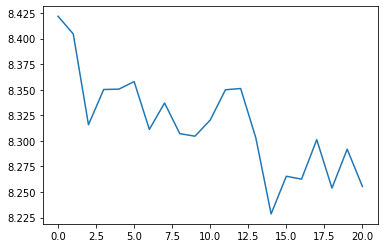

In [0]:
plt.plot(history)